In [1]:
from ftpr.visualization import PhaseVisualizer
from mplsoccer import Pitch
import pandas as pd
from ftpr.dataloader import load_phases
from ftpr.representation import MultiParallelDescritizer, MultiSequentialDescritizer, EventDescretizer, LocationDescretizer, CMSPADEWriter
from ftpr.miner import find_patterns, rank_patterns, run_miner
from ftpr.preprocessing import PhaseExtractor
from ftpr.clustering import PhaseClustering
import numpy as np
from spmf import Spmf

In [2]:
team = 'Manchester City'
df = pd.read_csv(f'../data/team_phases/{team}.csv')
phases = load_phases(df, filter_static_events=True, min_phase_length=3, n_jobs=5)

In [3]:
clustering = PhaseClustering(phases)

In [4]:
n_clusters = 100
cls_pred, agg_clustering = clustering.agglomerative_fit(n_clusters=n_clusters, metric='dtw')

In [5]:
cluster_scores = clustering.get_cluster_scores(metric='shot')
best_cluster_indeces = np.argsort(cluster_scores)[::-1]

In [6]:
ith = 0
phases_in_cluster = clustering.get_cluster_phases(best_cluster_indeces[ith])
series_in_cluster = clustering.get_cluster_series(best_cluster_indeces[ith])

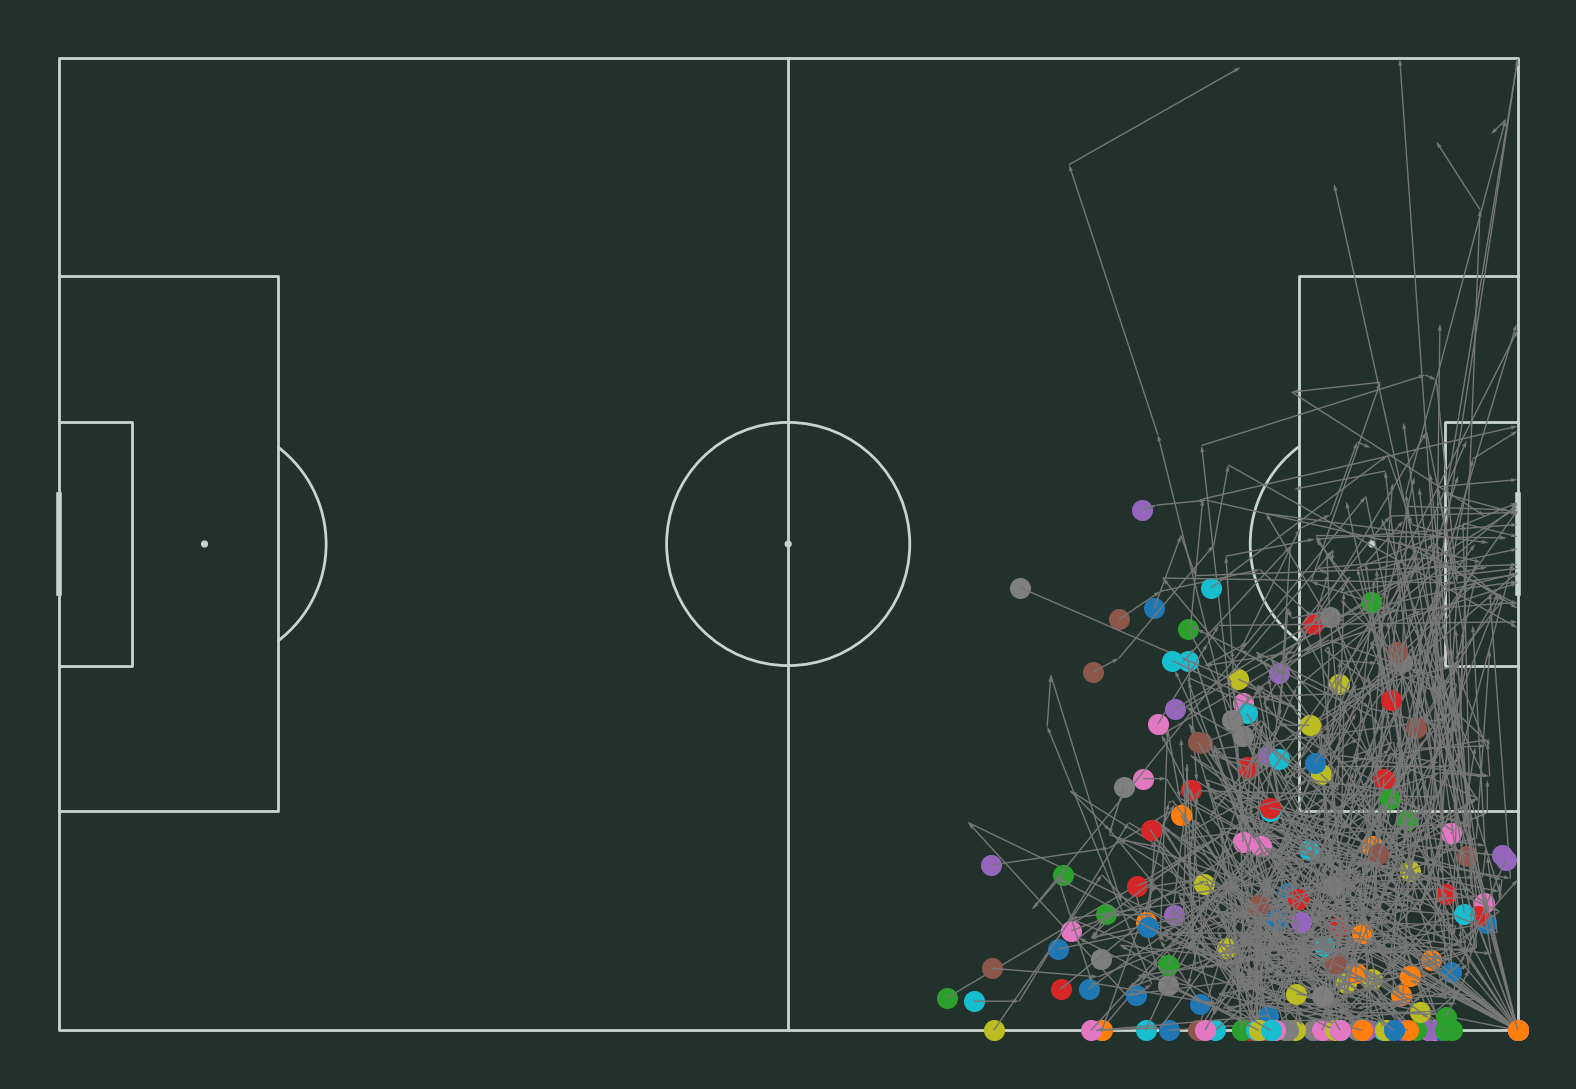

In [7]:
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#22312b')

pv = PhaseVisualizer((8, 5))

for ser in series_in_cluster:
    pitch.scatter(ser[0, 0], ser[0, 1], s=200, ax=ax)
    for i in range(len(ser) - 1):
        pitch.arrows(ser[i, 0], ser[i, 1], ser[i + 1, 0], ser[i + 1, 1],
                        color='#777777', ax=ax, width=1)


In [8]:
event_types = {
	'pass': ['corner', 'free kick', 'goal kick', 'interception', 'kick off', 'recovery', 'throw-in']
}
event_des = EventDescretizer('event', events=PhaseExtractor.HAVING_BALL_EVENTS, event_types=event_types)
location_des = LocationDescretizer('location')
multi_des = MultiSequentialDescritizer('multi', descretizers=[event_des, location_des])

In [9]:
next(multi_des.apply([phases_in_cluster[2]]))

[(7, 14), (18,), (7,), (18,), (0,), (18,), (7,), (18,)]

In [10]:
mapping = multi_des.get_decode_mapping()
mapping

{0: 'carry',
 1: 'ball recovery',
 2: 'goal keeper',
 3: 'clearance',
 4: 'interception',
 5: 'dribble',
 6: 'shot',
 7: 'pass',
 8: 'pass_corner',
 9: 'pass_free kick',
 10: 'pass_goal kick',
 11: 'pass_interception',
 12: 'pass_kick off',
 13: 'pass_recovery',
 14: 'pass_throw-in',
 15: 'block',
 17: 'Left Flank',
 18: 'Right Flank',
 19: 'Own box',
 20: 'Opposition box',
 21: 'Midfield'}

In [11]:
scores = {
    0: 0.5,
	1: 1,
	2: 0.25,
	3: 1,
	4: 1,
	5: 0.5,
	6: 2,
	7: 0.5,
	8: 0.5,
	9: 0.5,
	10: 0.5,
	11: 0.5,
	12: 0.5,
	13: 0.5,
 	14: 0.5,
	15: 0.25
}

In [12]:
writer = CMSPADEWriter()

In [13]:
multi_des.apply(phases_in_cluster)

<generator object Descretizer.apply at 0x32b6aa970>

In [14]:
writer.write(multi_des.apply(phases_in_cluster, mode='sequential'), 'testtt.txt')

In [15]:
df = run_miner(algorithm="VMSP", input_filename="testtt.txt",
            output_filename="output.txt", arguments=["5%", "100", "1"])

>/Users/bobby/Desktop/Projects/ftpr/notebooks/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 23 ms
 Frequent sequences count : 29
 Max memory (mb) : 12.01570892333984429
minsup 10
Intersection count 652 




# Analyzing the Result

In [16]:
df['sup'] = df['sup'] / len(phases_in_cluster)
df

,pattern,sup
21,"[18, 7, 18, 0, 18, 7, 18, 7]",0.076923
20,"[1, 18, 0, 18, 7, 18, 0]",0.076923
6,"[0, 21, 7, 21]",0.076923
15,"[7, 18, 7, 18, 7, 18]",0.076923
3,"[21, 0, 21]",0.065934
7,"[7, 20, 0, 20]",0.065934
19,"[7 13, 18, 0, 18, 7, 18]",0.065934
11,"[7 8, 18, 7]",0.065934
12,"[7 8, 18, 0]",0.065934
0,"[1, 21]",0.060440


In [17]:
find_patterns(df, '6')

,pattern,sup
4,"[7, 20, 6, 20]",0.054945


In [18]:
df = rank_patterns(df, scores, mapping)
df

,pattern,translate,score
21,"[7, 20, 6, 20]","[(pass,), (Opposition box,), (shot,), (Opposit...",0.034341
9,"[1, 21]","[(ball recovery,), (Midfield,)]",0.030220
1,"[1, 18, 0, 18, 7, 18, 0]","[(ball recovery,), (Right Flank,), (carry,), (...",0.027473
8,"[7 8, 18, 0]","[(pass, pass_corner), (Right Flank,), (carry,)]",0.024725
7,"[7 8, 18, 7]","[(pass, pass_corner), (Right Flank,), (pass,)]",0.024725
18,"[1, 20, 0, 20]","[(ball recovery,), (Opposition box,), (carry,)...",0.020604
0,"[18, 7, 18, 0, 18, 7, 18, 7]","[(Right Flank,), (pass,), (Right Flank,), (car...",0.019231
3,"[7, 18, 7, 18, 7, 18]","[(pass,), (Right Flank,), (pass,), (Right Flan...",0.019231
2,"[0, 21, 7, 21]","[(carry,), (Midfield,), (pass,), (Midfield,)]",0.019231
6,"[7 13, 18, 0, 18, 7, 18]","[(pass, pass_recovery), (Right Flank,), (carry...",0.018838


In [19]:
find_patterns(df, '6')

,pattern,translate,score
21,"[7, 20, 6, 20]","[(pass,), (Opposition box,), (shot,), (Opposit...",0.034341


In [20]:
for t in df.iloc[:10]['translate']:
    print(t)

[('pass',), ('Opposition box',), ('shot',), ('Opposition box',)]
[('ball recovery',), ('Midfield',)]
[('ball recovery',), ('Right Flank',), ('carry',), ('Right Flank',), ('pass',), ('Right Flank',), ('carry',)]
[('pass', 'pass_corner'), ('Right Flank',), ('carry',)]
[('pass', 'pass_corner'), ('Right Flank',), ('pass',)]
[('ball recovery',), ('Opposition box',), ('carry',), ('Opposition box',)]
[('Right Flank',), ('pass',), ('Right Flank',), ('carry',), ('Right Flank',), ('pass',), ('Right Flank',), ('pass',)]
[('pass',), ('Right Flank',), ('pass',), ('Right Flank',), ('pass',), ('Right Flank',)]
[('carry',), ('Midfield',), ('pass',), ('Midfield',)]
[('pass', 'pass_recovery'), ('Right Flank',), ('carry',), ('Right Flank',), ('pass',), ('Right Flank',)]
